# Text classification 
## Sentiment analysis
It is a natural language processing problem where text is understood and the underlying intent is predicted. Here, you need to  predict the sentiment of movie reviews as either positive or negative in Python using the Keras deep learning library.

## Data description
The dataset is the Large Movie Review Dataset often referred to as the IMDB dataset.

The [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) (often referred to as the IMDB dataset) contains 25,000 highly polar movie reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given moving review has a positive or negative sentiment.  Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).

## Loading dataset
First, we will load complete dataset and analyze some properties of it.<br>


In [0]:
import numpy as np
from matplotlib import pyplot
import numpy
import keras
from keras import regularizers,layers
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [0]:
# np.load is used inside imdb.load_data. But imdb.load_data still assumes the default 
# values of an older version of numpy. So necessary changes to np.load are made

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load Numpy
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)



In [0]:
# call load_data with allow_pickle implicitly set to true
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

# restore np.load for future normal usage
np.load = np_load_old

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

print(X.shape)
print(X_train.shape)

(50000,)
(25000,)


In [0]:
X.shape[1:]

()

## **Let's see some of reviews.**

In [0]:
word_to_id = keras.datasets.imdb.get_word_index()
id_to_word = {value:key for key,value in word_to_id.items()}
for i in range(15,20):
  print("********************************************")
  print(' '.join(id_to_word.get(id - 3, '?')for id in X_train[i] ))

********************************************
? a total waste of time just throw in a few explosions non stop fighting exotic cars a deranged millionaire slow motion computer generated car crashes and last but not least a hugh ? like character with wall to wall hot babes and mix in a ? and you will have this sorry excuse for a movie i really got a laugh out of the dr evil like heavily ? compound the plot was somewhere between preposterous and non existent how many ? are willing to make a 25 million dollar bet on a car race answer 4 but didn't they become ? through ? responsibility this was written for ? males it plays like a video game i did enjoy the ? ii landing in the desert though
********************************************
? laputa castle in the sky is the bomb the message is as strong as his newer works and more pure fantastic and flying pirates how could it be any better the art is totally amazing and the soundtrack which is ? many times after this im not sure if this was the fi

## Summarize the data
1) Find out the number of classes in label (*y* array)? <br>
2) Find out number of unique words in dataset *X*?  <br>
3) Calculate the list of review length , report mean and standard deviation. <br>

In [0]:
def summarize_data():
  """
  Output:
                    classes: list, list of unique classes in y  
                no_of_words: int, number of unique words in dataset x 
     list_of_review_lengths: list,  list of lengths of each review 
         mean_review_length: float, mean(list_of_review_lengths), a single floating point value
          std_review_length: float, standard_deviation(list_of_review_lengths), a single floating point value
  """
  # YOUR CODE HERE
  z=np.array(y)
  classes = np.array(sorted(list(set(z))))
  cnt=0
  curr={}
  list_of_review_lengths=[]
  for l in X:
    list_of_review_lengths.append(len(l))
    for ele in l:
      curr[ele]=1
  no_of_words=len(curr.keys())
  mean_review_length=sum(list_of_review_lengths)/X.shape[0]
  std_review_length=np.array(list_of_review_lengths).std()
  return classes, no_of_words, list_of_review_lengths, mean_review_length, std_review_length


classes, no_of_words, list_of_review_lengths, mean_review_length, std_review_length = summarize_data()


In [0]:
'''test for summarize_data'''
def test_summarize_data():
  assert classes.tolist() == [0,1]
  assert no_of_words == 9998
  assert np.isclose(mean_review_length, 234.75892, atol = 0.001)
  assert np.isclose(std_review_length, 172.91149458735703, atol = 0.001)
  print('Test passed', '\U0001F44D')
test_summarize_data()

Test passed 👍


In [0]:
type(y_train)

numpy.ndarray

## One hot encode the output data

In [0]:
def one_hot(y):
  """
  Inputs:
    y: numpy array with class labels
  Outputs:
    y_oh: numpy array with corresponding one-hot encodings
  """
  # YOUR CODE HERE
  from keras.utils import to_categorical
  y_oh=to_categorical(y)
  return y_oh
y_train = one_hot(y_train)
y_test = one_hot(y_test)

### Multi-hot encode the input data

All sequences are of different length and our vocabulory size is 10K.  <br>
**To Do**<br>
1) Intialize vector of dimension 10,000 with value 0. <br>
2) For those tokens in a sequence which are present in Vocabulary make that position as 1 and keep all other positions filled with 0. <br>
For example, lets take Vocabulary = ['I': 0, ':1, 'eat: 2:' mango: 3, 'fruit':4, 'happy':5, 'you':6] <br>
We have two sequnces and 
Multi-hot encoding of both sequences will be of dimension:  7 (vocab size).<br>
1) *Mango is my favourite fruit* becomes *Mango ? ? ? fruit* after removing words which are not in my vocabulary. Hence multi hot encoding will have two 1's corresponding to mango and fruit i.e, [0, 0, 0, 1, 1, 0, 0] <br>
Similarly, <br>
  2) *I love to eat mango*  = *I ? ? eat mango*  =  [1, 1, 0, 1, 0, 0, 0]

In [0]:
def multi_hot_encode(sequences, dimension):
  """
    Input:
          sequences: list of sequences in X_train or X_test

    Output:
          results: mult numpy matrix of shape(len(sequences), dimension)
                  
  """
  # YOUR CODE HERE
  results=[]
  for l in sequences:
#     print(l)
    v=np.zeros(dimension)
    for ele in l:
      v[ele]=1
    results.append(v)
#   print(sequences)
  
  return np.array(results)



In [0]:
x_train = multi_hot_encode(X_train, 10000)
x_test = multi_hot_encode(X_test, 10000)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (25000, 10000)
x_test  (25000, 10000)


In [0]:
'''test for pad_sequences'''
def test_multi_hot_encode():
  assert np.sum(x_train[1]) == 121.0
  print('Test passed', '\U0001F44D')
test_multi_hot_encode()

Test passed 👍


## Split the data into train and validation

In [0]:
from sklearn.model_selection import train_test_split
x_strat, x_dev, y_strat, y_dev = train_test_split(x_train, y_train,test_size=0.40,random_state=0, stratify=y_train)

In [0]:
x_strat.shape[1:]

(10000,)

## Build Model
Build a multi layered feed forward network in keras. 

### Create the model

In [0]:
def create_model():
    """
    Output:
        model: A compiled keras model
    """
    # YOUR CODE HERE
#     model = Sequential()
#     model.add(Dense(10, input_dim=10000))
#     model.add(Dense(2, activation='softmax'))
#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     model.summary()
    from keras.layers import Input, Dense
    from keras.models import Model
    
    input_layer = Input(shape = (10000,))
    h1 = Dense(2)(input_layer)
    output_layer = Dense(2, activation = 'softmax')(h1)
    model = Model(inputs = [input_layer], outputs=[output_layer])
    model.compile(loss='categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    return model
  
model = create_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 20002     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6         
Total params: 20,008
Trainable params: 20,008
Non-trainable params: 0
_________________________________________________________________
None


### Fit the Model

In [0]:
import matplotlib.pyplot as plt
def fit(model):
    """
    Action:
        Fit the model created above using training data as x_strat and y_strat
        and validation_data as x_dev and y_dev, verbose=2 and store it in 'history' variable.
        
        evaluate the model using x_test, y_test, verbose=0 and store it in 'scores' list
    Output:
        scores: list of length 2
        history_dict: output of history.history where history is output of model.fit()
    """
    # YOUR CODE HERE
    history=model.fit(x_strat,y_strat, batch_size=200, epochs=80, verbose=0, validation_data=(x_dev, y_dev))
    history_dict=history.history
    scores=model.evaluate(x_test,y_test,verbose=0)
    return scores,history_dict
    
scores,history_dict = fit(model)    


In [0]:
Accuracy=scores[1]*100
print('Accuracy of your model is')
print(scores[1]*100)

Accuracy of your model is
84.988


In [0]:
history_dict['loss']

[0.5510249427954356,
 0.36414320548375445,
 0.27689894596735637,
 0.22540306568145752,
 0.19045202155907948,
 0.1639262941479683,
 0.14268974761168163,
 0.12565317302942275,
 0.11071864744027456,
 0.09827652086814244,
 0.08717656433582306,
 0.07794664775331815,
 0.06965652922789256,
 0.06206636438767115,
 0.05573042631149292,
 0.049632221609354016,
 0.04458860774834951,
 0.03999168117841085,
 0.03585604424277941,
 0.0325253243247668,
 0.029179428691665333,
 0.026258660033345222,
 0.023829129561781882,
 0.021460339799523352,
 0.01945297888169686,
 0.017684428778787453,
 0.016088579806188743,
 0.014592574077347915,
 0.013380927133063476,
 0.012148826929430166,
 0.011101266487191121,
 0.010151604854812224,
 0.009354350852469603,
 0.008640823513269424,
 0.007922323439270258,
 0.007318592797964811,
 0.006774757988750935,
 0.0062449590768665075,
 0.005766747786353032,
 0.005383405204241474,
 0.004969973424449563,
 0.004635443625350793,
 0.004313864180197319,
 0.004022501284877459,
 0.0037451

### Verify whether training in converged or not

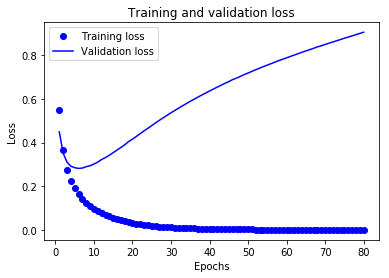

In [0]:
import matplotlib.pyplot as plt
plt.clf()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

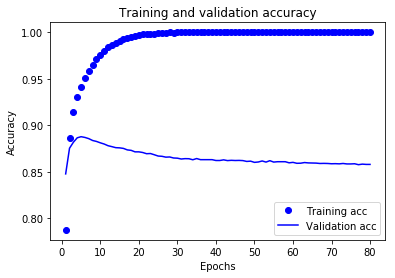

In [0]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Advanced
1. Find some reviews where your model fails to predict the sentiment correctly and give the reason why.
2. Write 5 reviews on your own with at least 20 words. See if your model correctly predicts the sentiment on these reviews


In [0]:
incorrects = np.nonzero(model.predict(x_test) != y_test)
incorrects[0]
for i in range(0,2):

  print(' '.join(id_to_word.get(id , '?')for id in incorrects[i] ))

********************************************
? ? the and and a a of of to to is is br in in it i i this that was was as for with with movie movie but film on not you you are are his his have he he be be one one all at at by by an an they who so from like like her her or just just about it's it's out out has if if some some there what good good more more when when very very up up no no time time she she even even my would would which which only only story story really really see see their had can were me me well well than we we much been bad bad get will will do do also also into into people people other other first first great because how how him him most most don't made its its then then way make them them too too could any any movies after after think think characters watch watch two two films character seen seen many many being life plot never never acting acting little little best best love love over where where did did show know know off off ever does does better better your your 

In [0]:
my_sentences=["total waste of time just throw in a few explosions non stop fighting exotic cars a deranged millionaire slow motion computer generated car crashes and last but not least a hugh ? like character ","the movie was frustatingly bad,i will never go to see such bad action comdy films even video quality was beyond bad","the movie was frustatingly good,but i will never go to see such bad action comdy films video quality was beyond bad"]
x=[]

for i in range(0,3):
  curr=[]
  for word in my_sentences[i].split():
    if word_to_id.get(word,'?')!='?':
      curr.append(int(word_to_id.get(word , '?')))
  x.append(list(curr))
# print(x)
reults=multi_hot_encode(x, 10000)
prec_y=model.predict(results)

[[961, 434, 4, 55, 40, 1399, 8, 3, 168, 3975, 698, 567, 994, 4176, 1877, 3, 5208, 5285, 547, 1267, 1219, 4888, 516, 6138, 2, 233, 18, 21, 219, 3, 3931, 37, 106], [1, 17, 13, 77, 112, 137, 5, 64, 138, 75, 203, 105, 57, 371, 486, 13, 721, 75], [1, 17, 13, 10, 77, 112, 137, 5, 64, 138, 75, 203, 105, 371, 486, 13, 721, 75]]


ValueError: ignored